In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tumor1234/Tumor_data/Tumor_data/data.yaml
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_0818.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_0596.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_1428.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_0540.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_1251.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_0470.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_0999.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_0525.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_1212.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/Tr-pi_1240.txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Pituitary/labels/p (780).txt
/kaggle/input/tumor1234/Tumor_data/Tumor_data

In [2]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 6.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import torch

sns.set_style('darkgrid')

%matplotlib inline

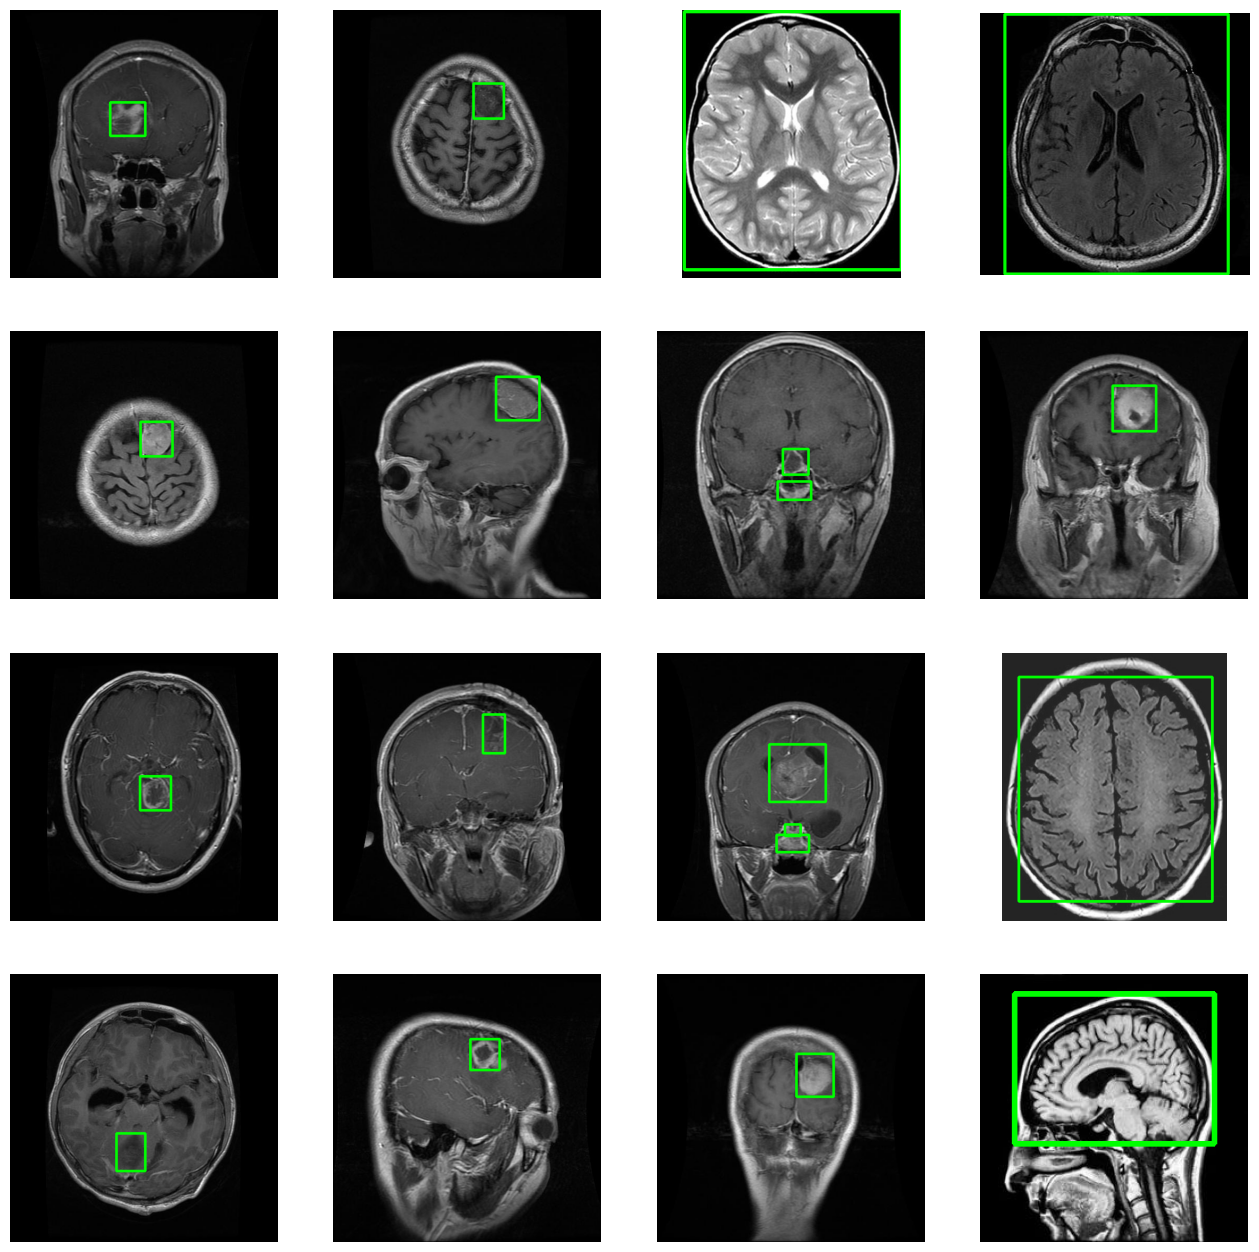

In [4]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the base paths to the dataset directories
train_dir = "/kaggle/input/tumor1234/Tumor_data/Tumor_data/Train"
val_dir = "/kaggle/input/tumor1234/Tumor_data/Tumor_data/Val"
test_dir = "/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test"  # Added test folder

# Define the tumor categories
categories = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Get all image and label file paths from the Train, Val, and Test directories
image_files = []
label_files = []

for category in categories:
    # Train Images and Labels
    train_images_path = os.path.join(train_dir, category, 'images')
    train_labels_path = os.path.join(train_dir, category, 'labels')
    
    # Val Images and Labels
    val_images_path = os.path.join(val_dir, category, 'images')
    val_labels_path = os.path.join(val_dir, category, 'labels')
    
    # Test Images and Labels
    test_images_path = os.path.join(test_dir, category, 'images')
    test_labels_path = os.path.join(test_dir, category, 'labels')

    # Collect images and labels from Train directory
    for image_file in os.listdir(train_images_path):
        image_path = os.path.join(train_images_path, image_file)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(train_labels_path, label_file)
        if os.path.exists(image_path) and os.path.exists(label_path):
            image_files.append(image_path)
            label_files.append(label_path)

    # Collect images and labels from Val directory
    for image_file in os.listdir(val_images_path):
        image_path = os.path.join(val_images_path, image_file)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(val_labels_path, label_file)
        if os.path.exists(image_path) and os.path.exists(label_path):
            image_files.append(image_path)
            label_files.append(label_path)
    
    # Collect images and labels from Test directory
    for image_file in os.listdir(test_images_path):
        image_path = os.path.join(test_images_path, image_file)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(test_labels_path, label_file)
        if os.path.exists(image_path) and os.path.exists(label_path):
            image_files.append(image_path)
            label_files.append(label_path)

# Choose 16 random images from the collected list (including Train, Val, and Test)
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_path in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image = cv2.imread(image_path)

    # Get the corresponding label path
    label_path = os.path.splitext(image_path.replace('images', 'labels'))[0] + ".txt"
    
    if not os.path.exists(label_path):
        continue  # Skip if no label file exists for this image

    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()


In [5]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/tumor1234/Tumor_data/Tumor_data/Train/Glioma/images/Te-glTr_0000.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 512x512 and 3 channels.


In [7]:
# Load YOLOv8 model
model = YOLO('yolov10x.pt')
# free up GPU memory
torch.cuda.empty_cache()

# Train the model
model.train(
    data='/kaggle/input/data-1/data.yaml',  # Path to your dataset YAML file
    epochs=50,                        # Number of epochs
    batch=8,                         # Batch size                     # Image size (adjust if needed)
    device='0'                        # Set to '0' for GPU or 'cpu' for CPU
)

100%|██████████| 61.4M/61.4M [00:00<00:00, 216MB/s] 


Ultralytics YOLOv8.2.95 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10x.pt, data=/kaggle/input/data-1/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]
2024-09-17 10:51:29,245	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-17 10:51:29,968	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1    213120  ultralytics.nn.modules.block.SCDown          [320, 640, 3, 2]              
  6                  -1  6   4604160  ultralytics.nn.modules.block.C2fCIB          [640, 640, 6, True]           
  7                  -1  1    417920  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 79.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/tumor1234/Tumor_data/Tumor_data/Train/Glioma/labels... 4737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:14<00:00, 317.79it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/tumor1234/Tumor_data/Tumor_data/Train/Glioma is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Glioma/labels... 254 images, 3 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:00<00:00, 281.11it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/tumor1234/Tumor_data/Tumor_data/Val/Glioma is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 185 weight(decay=0.0), 198 weight(decay=0.0005), 197 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.2G      2.363      4.068      2.842          2        640: 100%|██████████| 593/593 [06:26<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all        256        277      0.592      0.567      0.554      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.98G      2.523      2.884      2.927          0        640: 100%|██████████| 593/593 [06:17<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.652      0.471      0.518      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.91G      2.416      2.487      2.874          1        640: 100%|██████████| 593/593 [06:13<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.681      0.617      0.722      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.97G      2.257      2.224      2.758          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277        0.7      0.693      0.721      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.98G      2.232      2.049      2.723          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.752      0.813       0.82        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.98G      2.145      1.899      2.656          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.817      0.741      0.848       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.97G      2.093      1.833      2.627          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.813      0.789      0.853      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.97G      2.044      1.731      2.606          3        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.816      0.824      0.864      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.97G      2.024      1.654      2.605          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.819      0.779      0.832      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.97G      1.963      1.603      2.544          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.901      0.799      0.905      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.84G      1.924      1.463      2.528          3        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.876      0.807      0.903      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.98G      1.917       1.47      2.503          1        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.862      0.851      0.884      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.98G      1.915      1.466      2.519          2        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.872      0.894      0.918      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.97G      1.856      1.359      2.472          2        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.895      0.829      0.904      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.97G      1.838      1.351      2.469          2        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277       0.81      0.871      0.886      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.97G      1.805      1.314      2.446          2        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.872      0.908      0.924       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.97G      1.797      1.313      2.441          4        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.893      0.881      0.924      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.97G      1.762      1.236      2.415          1        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.902      0.894       0.93      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.84G      1.764      1.218      2.419          1        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.862      0.861      0.902      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.97G      1.744      1.222      2.413          1        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.918      0.853      0.924      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.97G      1.732      1.165      2.386          1        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.901       0.91      0.928      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.97G      1.719      1.149      2.383          1        640: 100%|██████████| 593/593 [06:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.883      0.872      0.913      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.97G      1.704      1.106      2.377          5        640: 100%|██████████| 593/593 [06:11<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.905      0.882      0.934      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.97G      1.709      1.125      2.372          4        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]

                   all        256        277      0.925      0.903      0.943       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.97G      1.676      1.083      2.355          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277        0.9      0.905      0.931       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.97G      1.675      1.079      2.346          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.914      0.875      0.932      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.84G      1.653      1.048      2.347          4        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.924      0.902      0.934      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.97G      1.624       1.03      2.338          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.896      0.905      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.97G      1.598      1.019      2.319          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.902      0.922      0.944      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.97G       1.59     0.9855      2.303          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277       0.93      0.877      0.946      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.97G      1.567     0.9601      2.289          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277       0.93      0.913      0.943      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.98G      1.603     0.9695      2.307          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.902      0.895      0.933      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.97G      1.542     0.9156      2.283          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.923      0.889      0.935      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.98G      1.554     0.9224      2.281          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.918      0.924      0.943      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.84G      1.563     0.9271      2.288          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.915      0.897      0.939       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.97G      1.524     0.8741      2.267          0        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.943      0.915      0.948       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.97G      1.511     0.8902      2.247          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.957      0.874       0.95      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.97G      1.498      0.848      2.238          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.935      0.909      0.948      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.97G      1.468     0.8469      2.224          0        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.916      0.918      0.939      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.97G      1.497     0.8488      2.254          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.949        0.9      0.947      0.764


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.97G      1.334     0.6809      2.179          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.932      0.913      0.948      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.97G      1.306     0.6561      2.143          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.917      0.923      0.951      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.85G      1.284     0.6212      2.122          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.926      0.927       0.95      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.97G      1.279     0.6212      2.119          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.937      0.923      0.949       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.97G      1.244     0.5857      2.103          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.938      0.921       0.95       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.97G      1.228      0.575      2.089          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.937      0.924       0.95      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.97G      1.206     0.5623      2.066          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.947      0.897      0.949      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.98G      1.203       0.55      2.066          1        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]

                   all        256        277      0.952      0.909       0.95      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.97G      1.171     0.5501      2.049          1        640: 100%|██████████| 593/593 [06:11<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        256        277      0.942      0.911       0.95      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.97G       1.17     0.5383      2.048          2        640: 100%|██████████| 593/593 [06:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        256        277      0.937      0.915      0.948      0.786



50 epochs completed in 5.339 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 64.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 64.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10x summary (fused): 503 layers, 31,591,784 parameters, 0 gradients, 169.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


                   all        256        277      0.943      0.908      0.949      0.787
                Glioma         67         76      0.942      0.853      0.921      0.774
            Meningioma         70         71      0.963      0.986      0.992      0.832
              No Tumor         48         48      0.979      0.976      0.989      0.851
             Pituitary         78         82      0.887      0.817      0.897      0.692
Speed: 0.2ms preprocess, 28.0ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0cab1fd750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

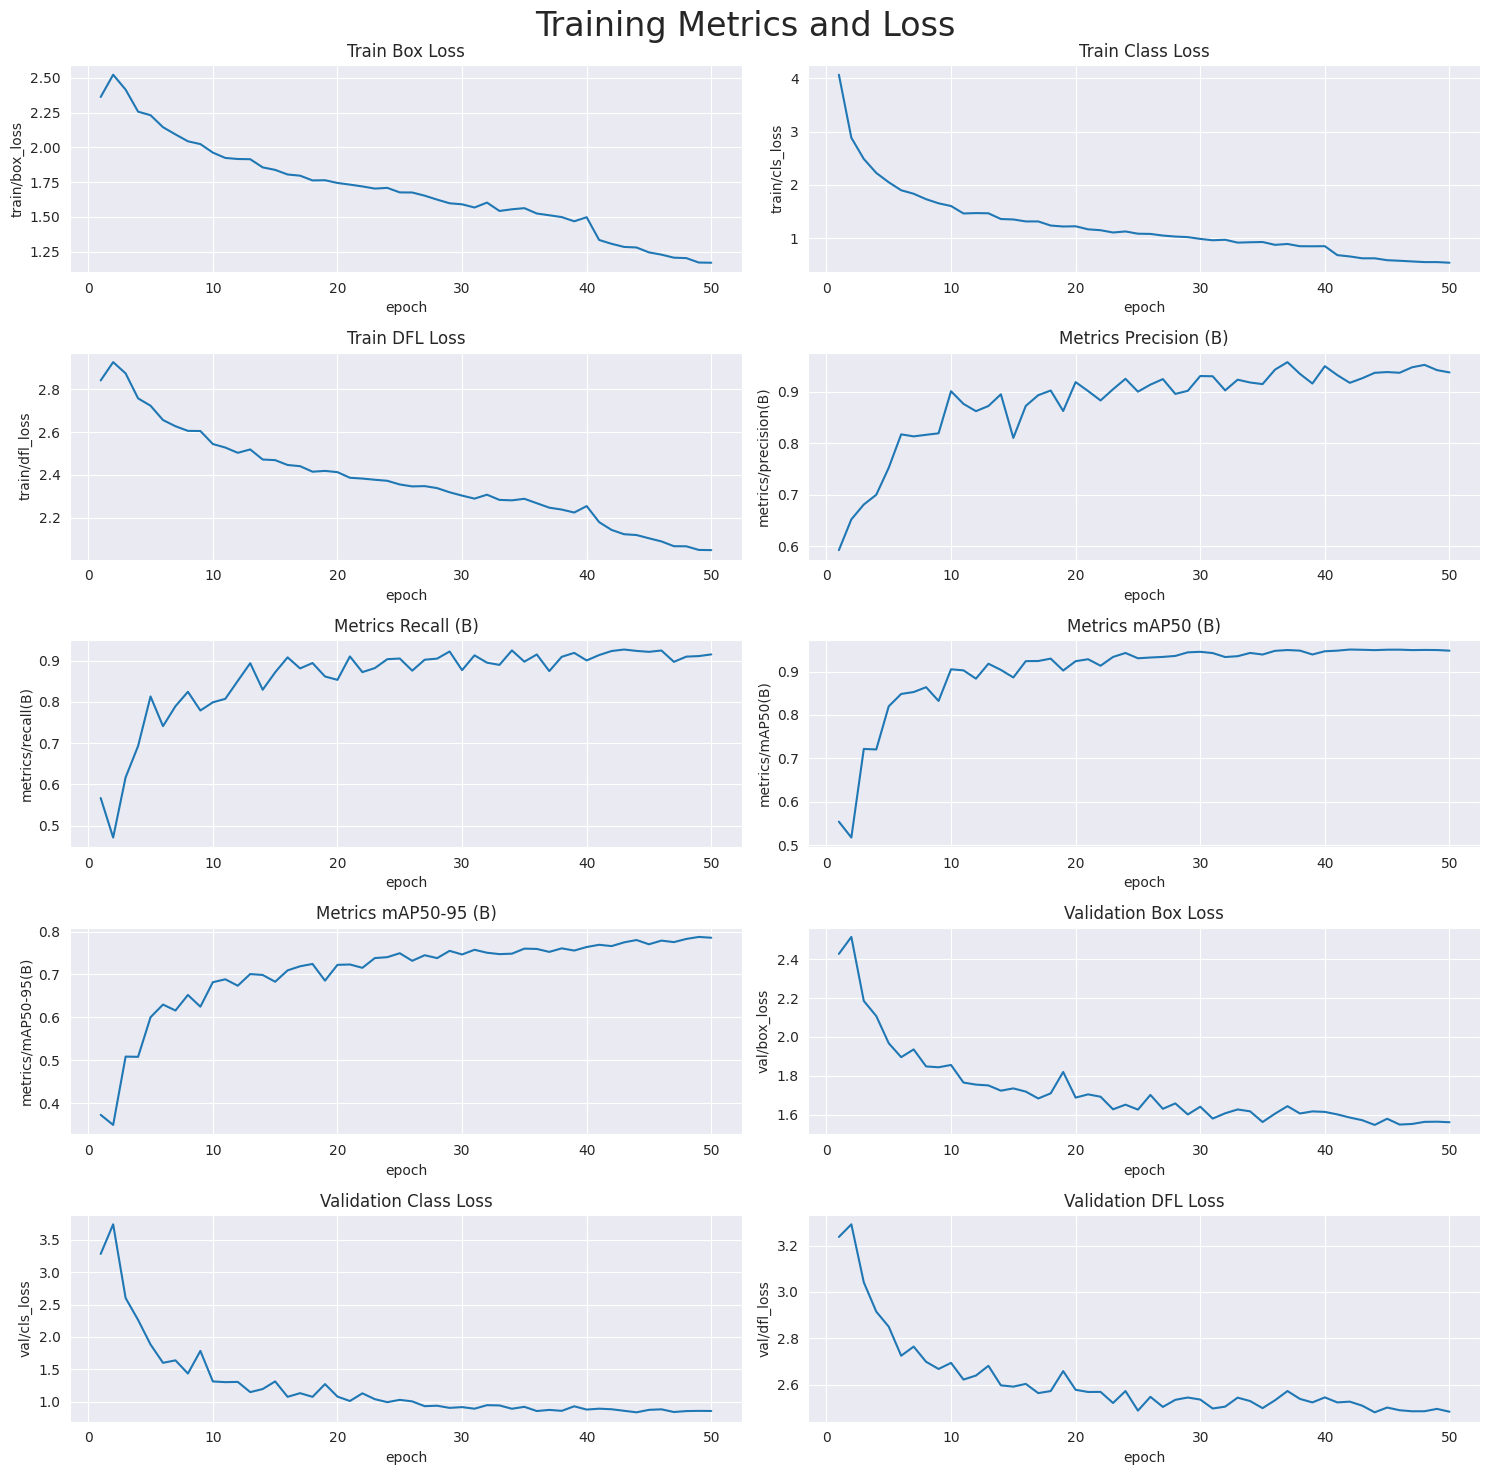

In [8]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [9]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.2.95 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10x summary (fused): 503 layers, 31,591,784 parameters, 0 gradients, 169.8 GFLOPs


val: Scanning /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/labels... 256 images, 0 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:01<00:00, 235.84it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


                   all        256        277      0.956      0.944      0.969      0.826
                Glioma         68         77      0.861      0.886      0.935      0.783
            Meningioma         70         71          1      0.997      0.995      0.862
              No Tumor         50         50          1       0.98       0.99      0.865
             Pituitary         76         79      0.965      0.911      0.955      0.794
Speed: 0.2ms preprocess, 71.5ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val


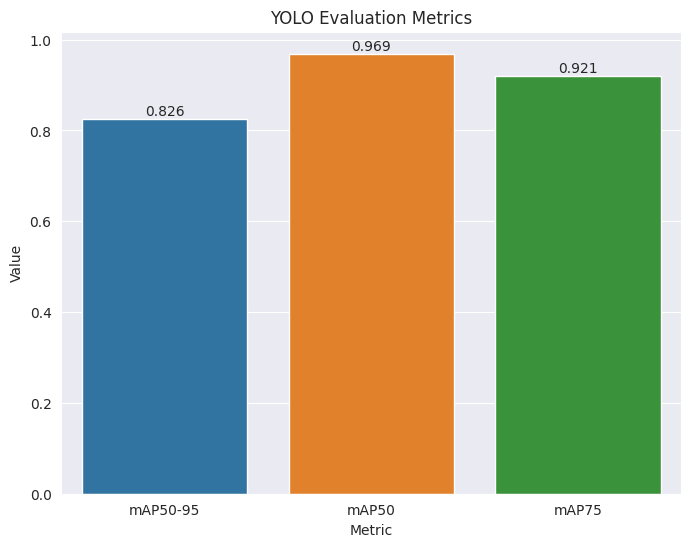

In [10]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()

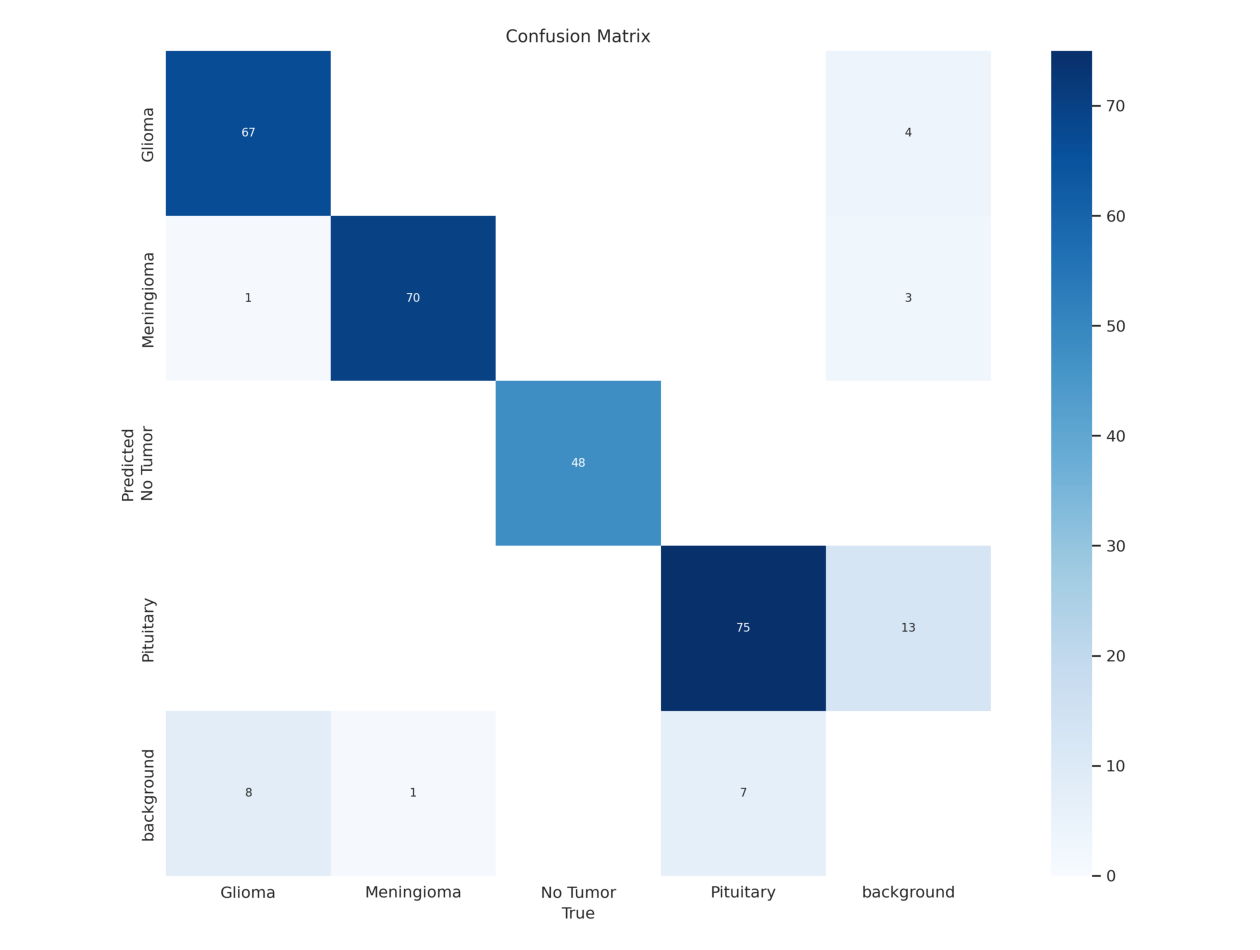

In [11]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (16, 16))

ax.imshow(img)
ax.axis('off');

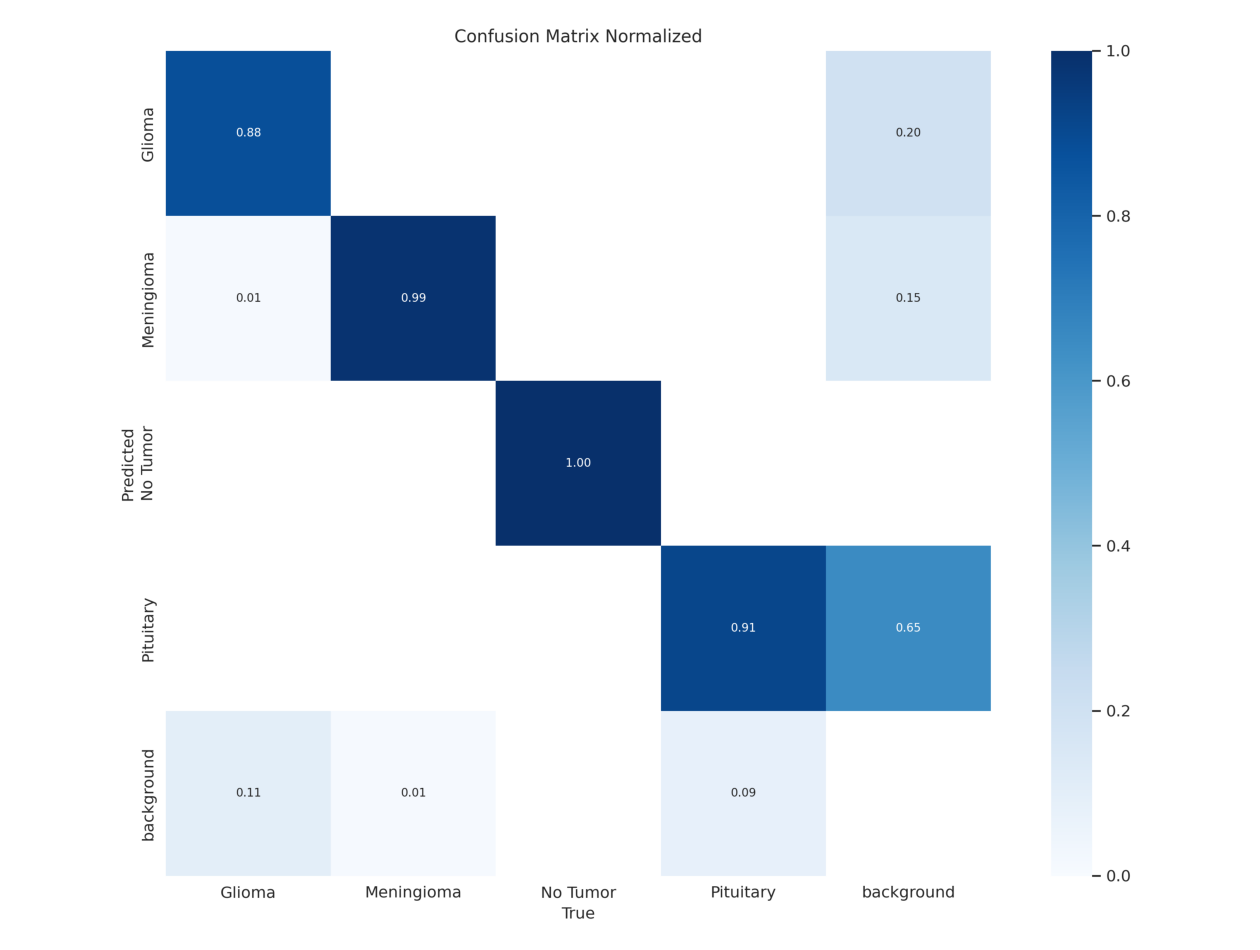

In [12]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix_normalized.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (16, 16))

ax.imshow(img)
ax.axis('off');

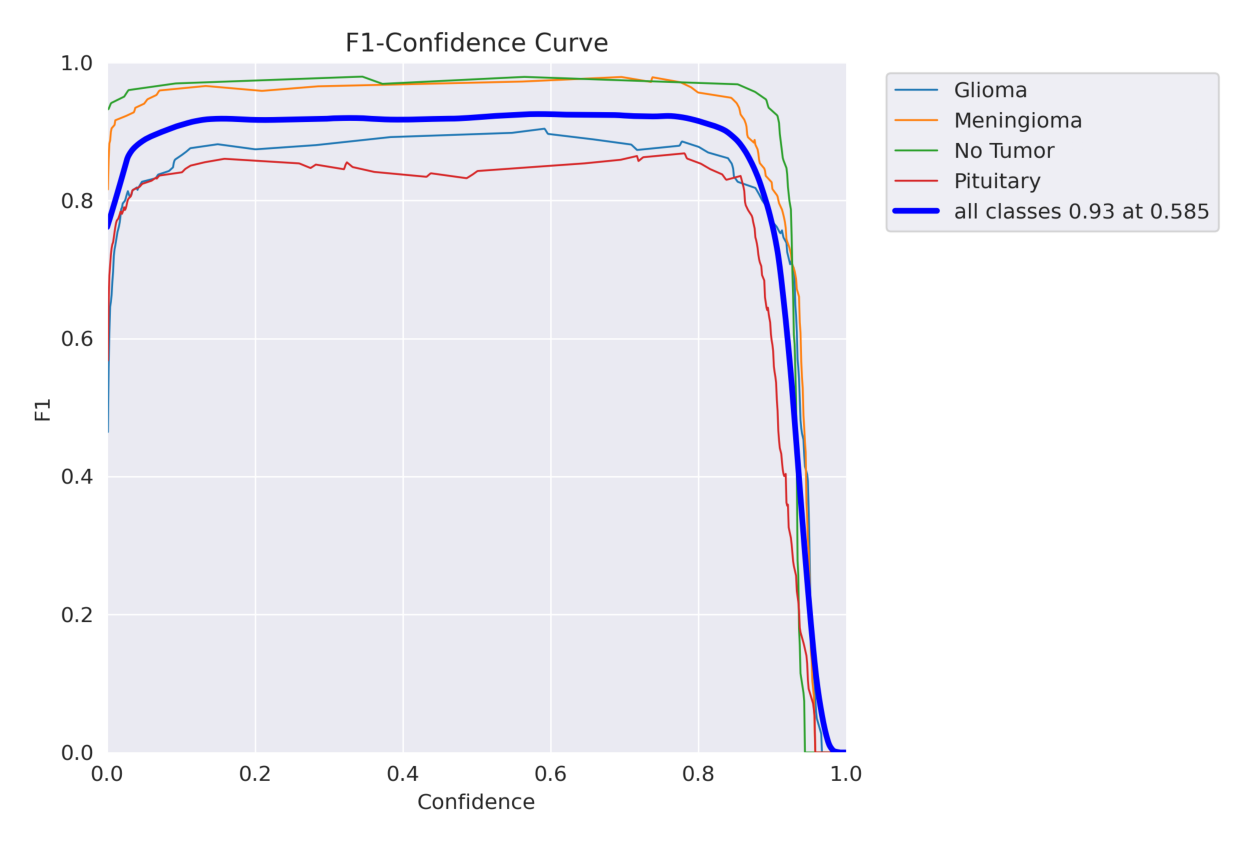

In [13]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/F1_curve.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (16, 16))

ax.imshow(img)
ax.axis('off');

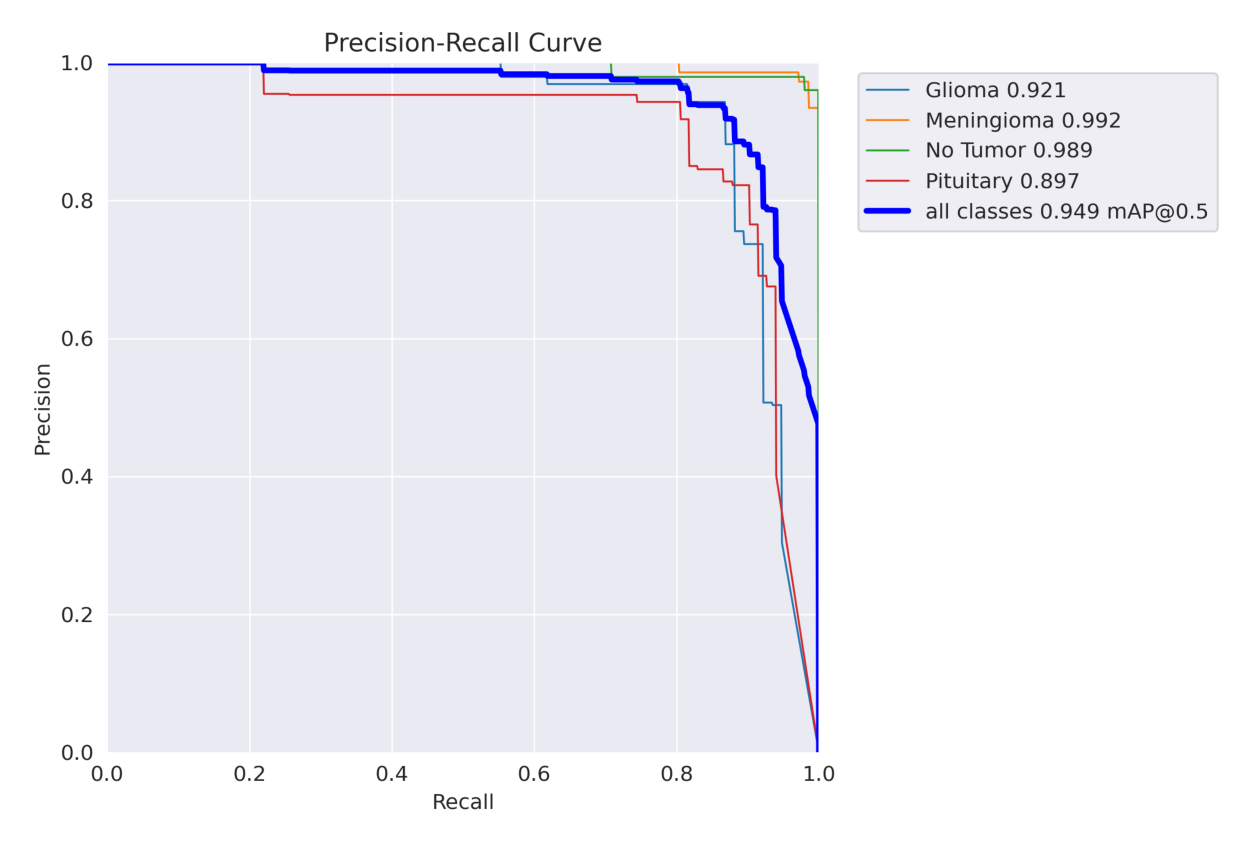

In [14]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/PR_curve.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (16, 16))

ax.imshow(img)
ax.axis('off');

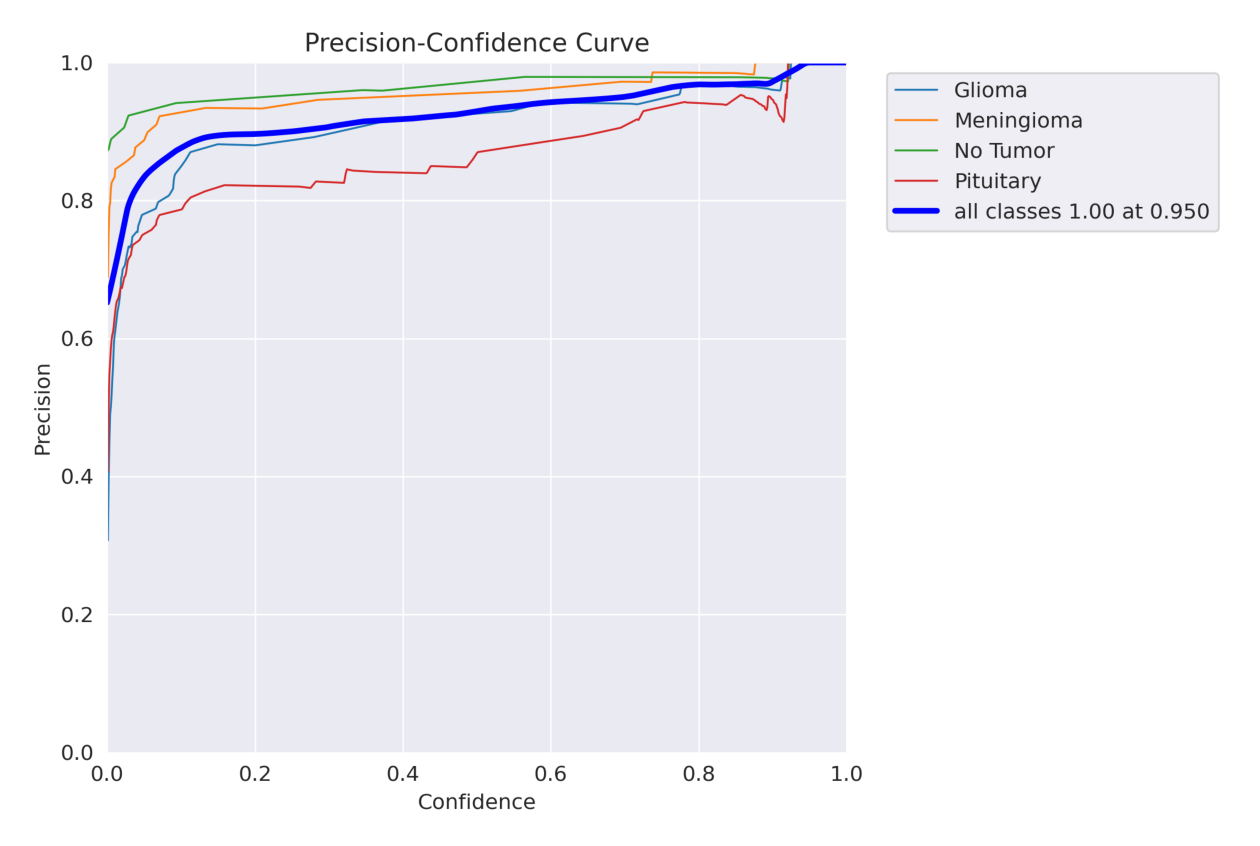

In [15]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/P_curve.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (16, 16))

ax.imshow(img)
ax.axis('off');

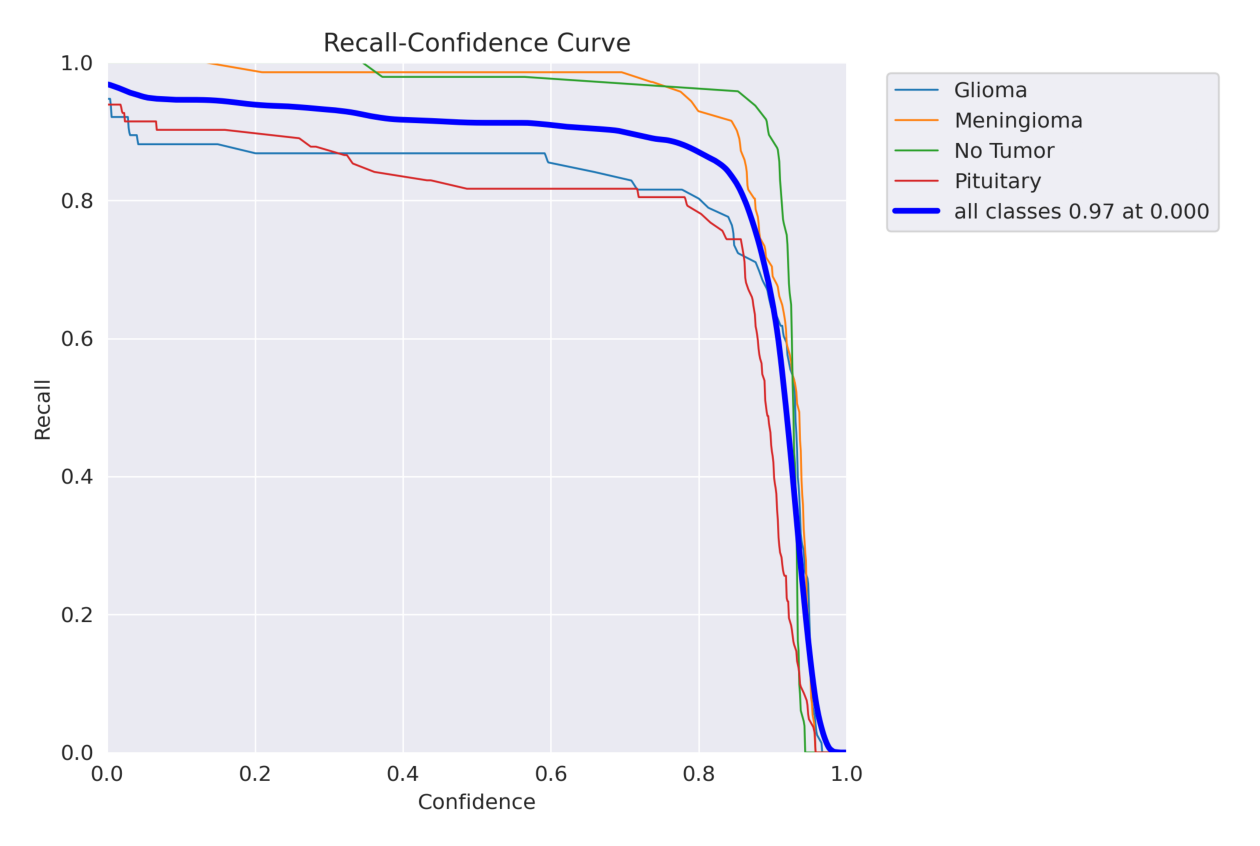

In [16]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/R_curve.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (16, 16))

ax.imshow(img)
ax.axis('off');

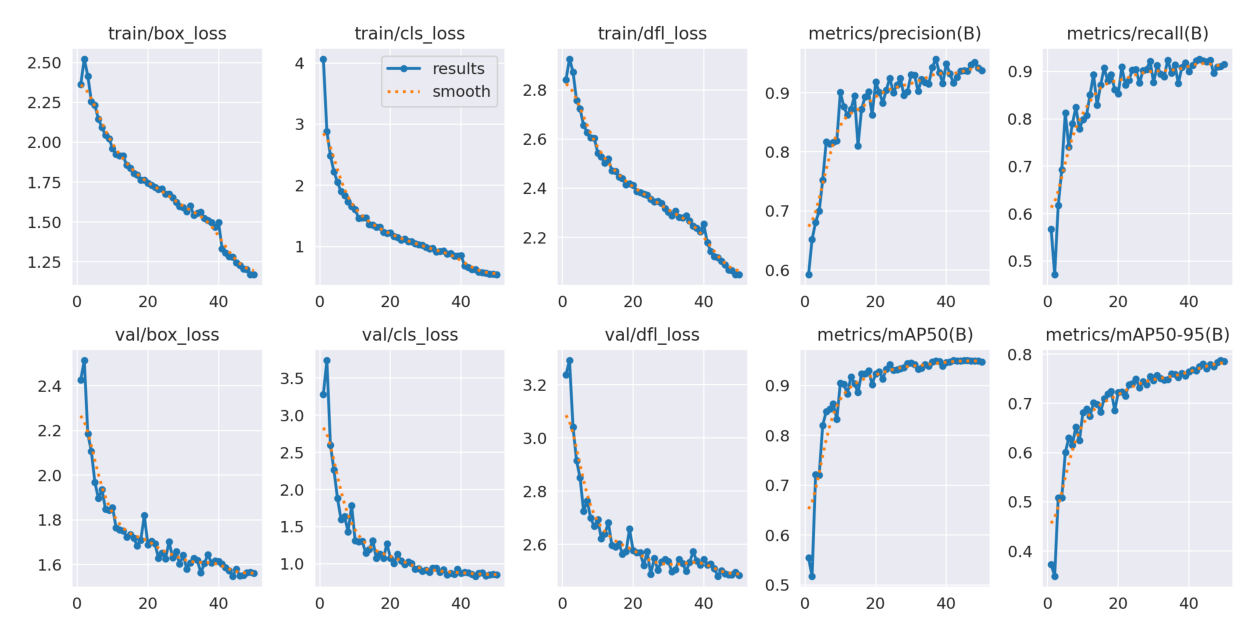

In [17]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/results.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (16, 16))

ax.imshow(img)
ax.axis('off');

In [18]:
# Function to perform ship detections
def Tumor_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 1 Glioma, 69.2ms
Speed: 4.3ms preprocess, 69.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 60.4ms
Speed: 2.5ms preprocess, 60.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 No Tumor, 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Pituitary, 51.6ms
Speed: 2.4ms preprocess, 51.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


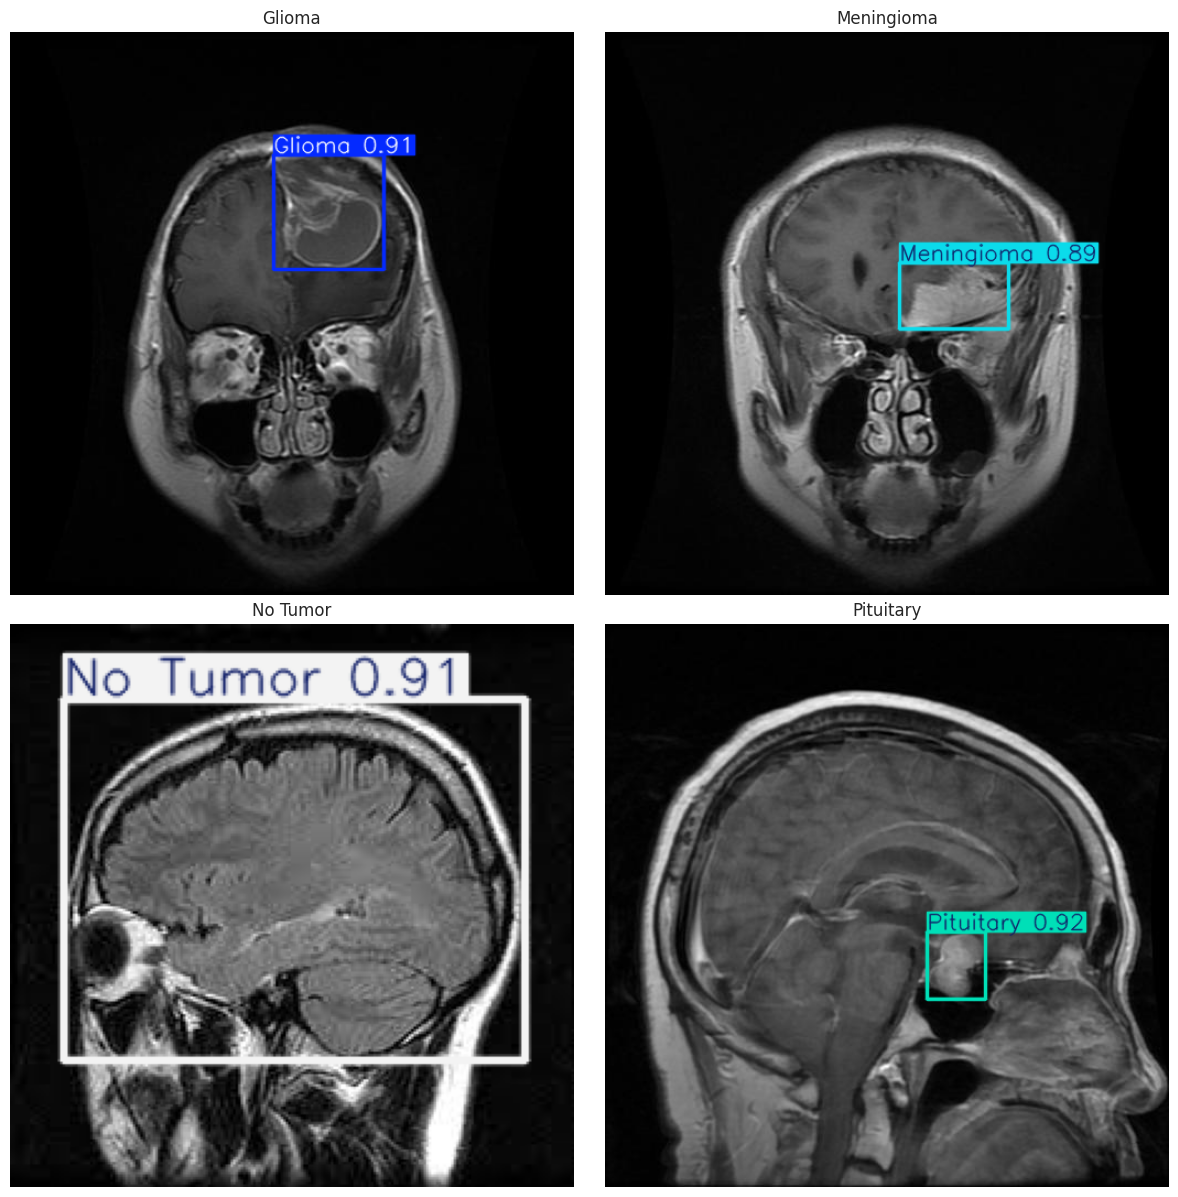

In [19]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image  # Ensure you have PIL or Pillow installed

# Define the base directory where the test data is stored
test_base_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List of class names
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Create a list to store paths of selected images
selected_images = []

# Select 1 random image from each class
for class_name in class_names:
    class_image_dir = os.path.join(test_base_dir, class_name, 'images')
    
    # Get the list of image files in the current class directory
    image_files = os.listdir(class_image_dir)
    
    # Select a random image from the class directory
    selected_image = random.choice(image_files)
    selected_images.append(os.path.join(class_image_dir, selected_image))

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_path in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 2
    col_idx = i % 2
    
    try:
        # Open and process the image
        detect_img = Tumor_detect(img_path)  # Ensure Tumor_detect function is defined and works properly
        axes[row_idx, col_idx].imshow(detect_img)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        axes[row_idx, col_idx].text(0.5, 0.5, 'Error', fontsize=12, ha='center')

    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(class_names[i])

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


In [20]:

# Path to your trained model weights
model_weights_path = '/kaggle/working/runs/detect/train/weights/best.pt'

# Load the trained YOLO model
trained_model = YOLO(model_weights_path)

# Path to your test images directory
test_images_path = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# Predict for each class directory
for class_dir in ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']:
    class_images_path = f'{test_images_path}/{class_dir}/images'
    predictions = trained_model.predict(
        source=class_images_path,
        conf=0.4,
        save_txt=True,
        save_conf=True
    )
    print(f'Predictions for {class_dir}:', predictions)


image 1/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0202.jpg: 640x640 1 Glioma, 80.9ms
image 2/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0245.jpg: 640x640 1 Glioma, 54.0ms
image 3/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0307.jpg: 640x640 1 Glioma, 49.8ms
image 4/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0327.jpg: 640x640 1 Glioma, 51.2ms
image 5/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0343.jpg: 640x640 1 Glioma, 1 Pituitary, 52.6ms
image 6/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0369.jpg: 640x640 1 Glioma, 51.0ms
image 7/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0372.jpg: 640x640 1 Glioma, 51.7ms
image 8/68 /kaggle/input/tumor1234/Tumor_data/Tumor_data/Test/Glioma/images/Tr-gl_0474.jpg: 640x640 1 Glioma, 50.7ms
image 9/68 /kaggle/input/tumor1234/Tumor_data/Tumo

In [21]:
print(predictions[4])

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0

In [22]:
predictions_save_dir = '/kaggle/working/' + predictions[0].save_dir + '/labels'

In [23]:
import os
import cv2

def draw_bbox(file_path, filename, img):
    # Read the label file for the bounding box
    with open(os.path.join(file_path, f'{filename}.txt'), 'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        f.close()

    # Extract class, bounding box coordinates and probability (if available)
    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    
    # Convert YOLO format (x, y, w, h) into bounding box coordinates (x1, y1, x2, y2)
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    # Define class names and colors
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    class_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Assign unique colors for each class
    
    # Get the label and color for the bounding box
    label = class_names[tumor_class]
    colour = class_colors[tumor_class]

    # Check if there's a probability/confidence score and append it to the label
    if len(labels) > 6:
        prob = float(labels[6])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    # Draw the bounding box and label on the image
    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

    return img


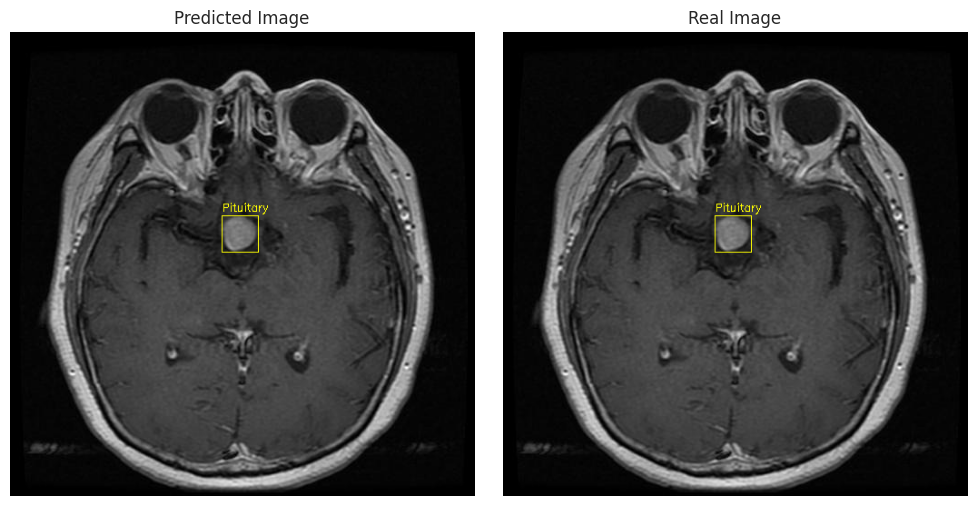

In [24]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


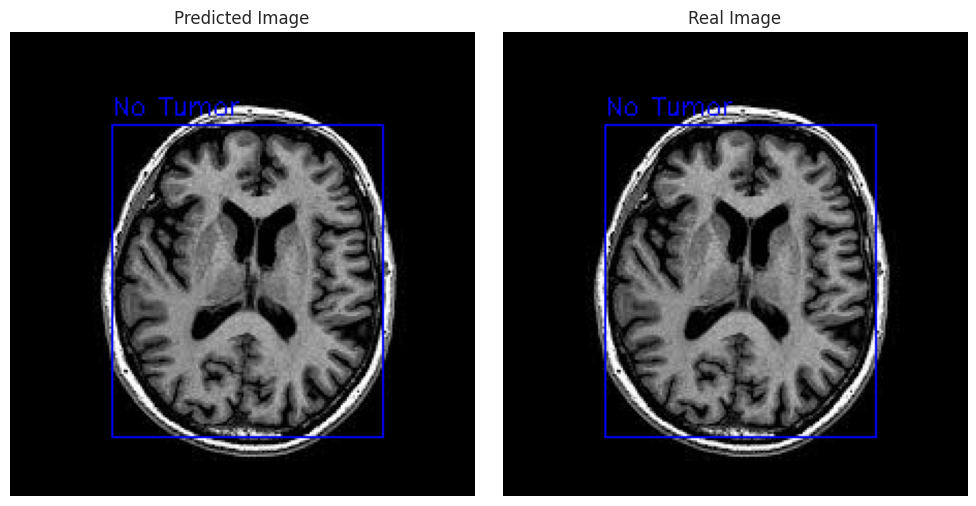

In [25]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


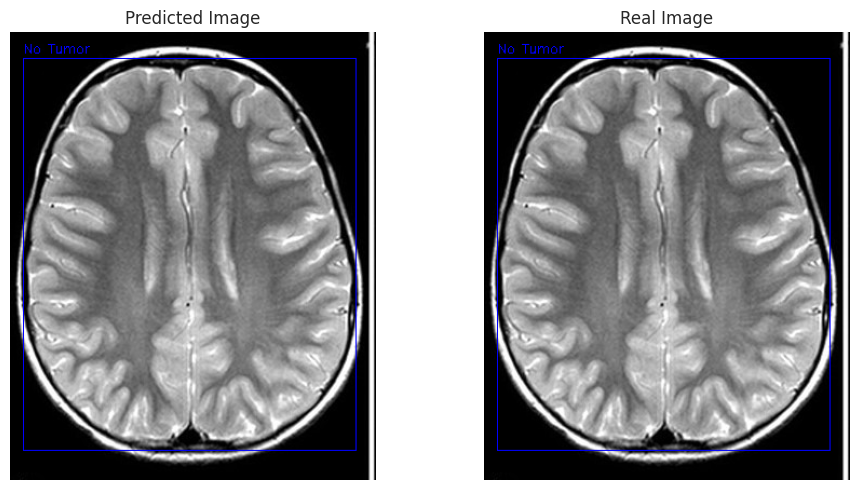

In [26]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


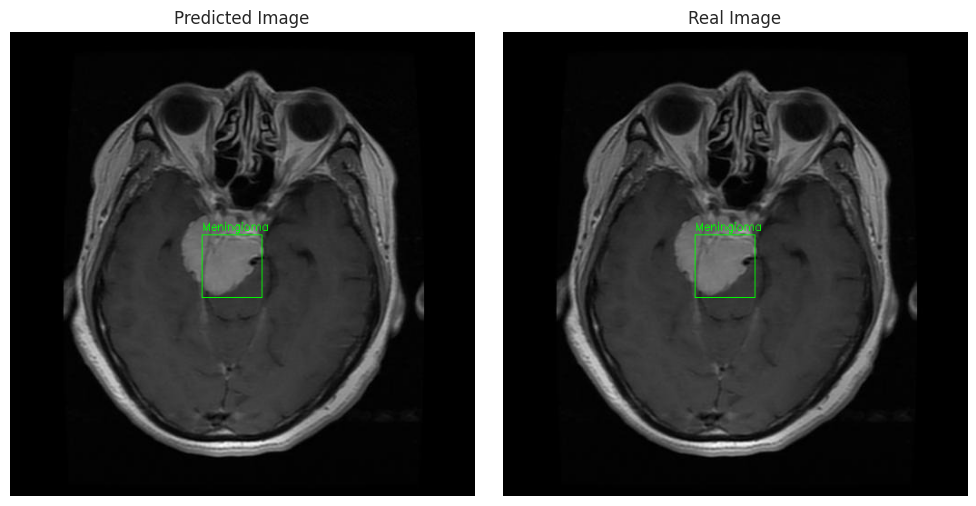

In [27]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


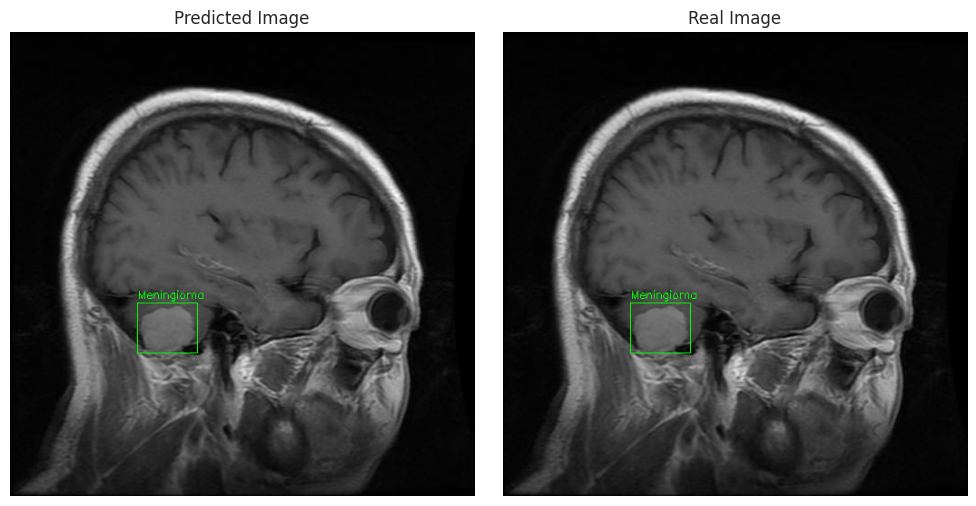

In [28]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


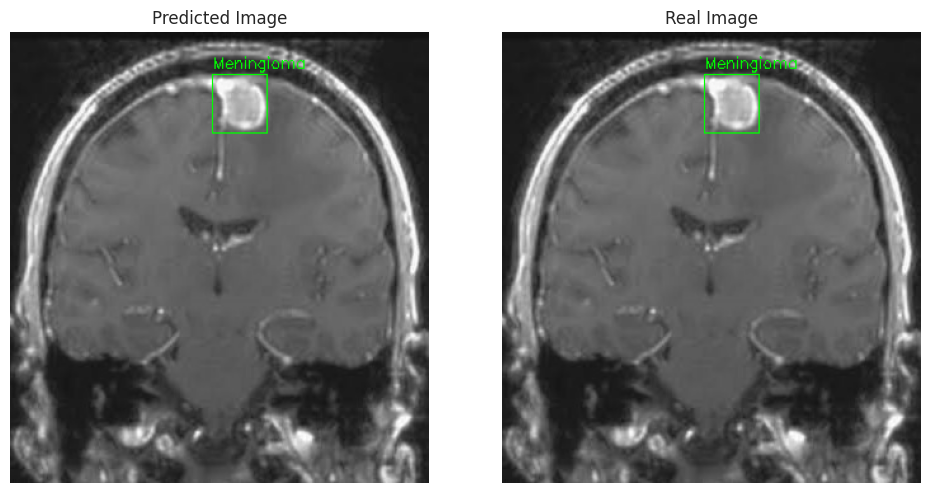

In [29]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


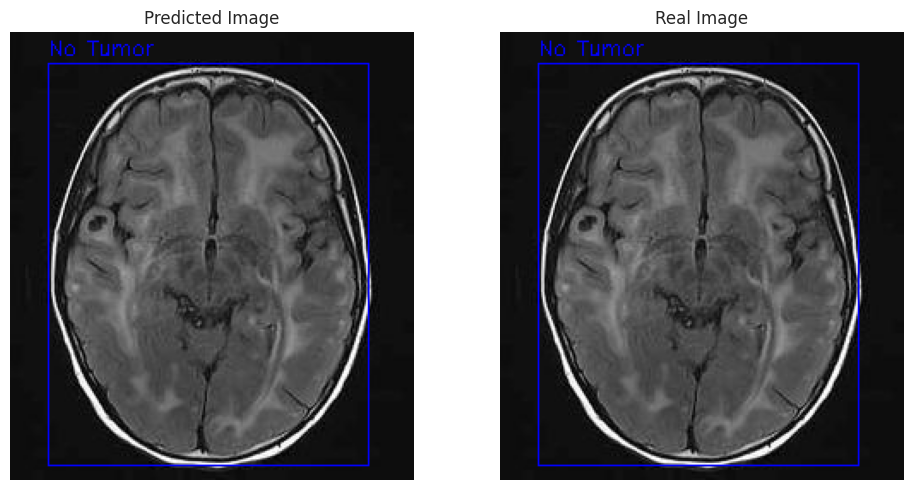

In [30]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


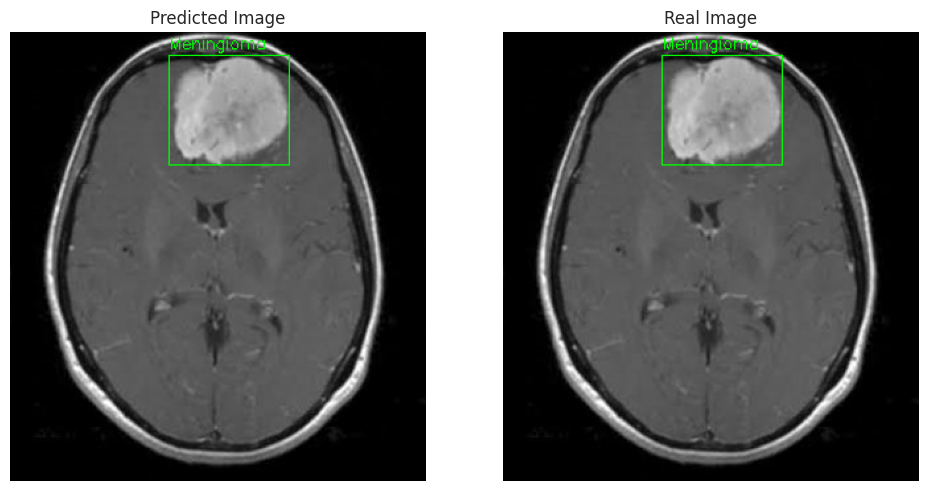

In [31]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")


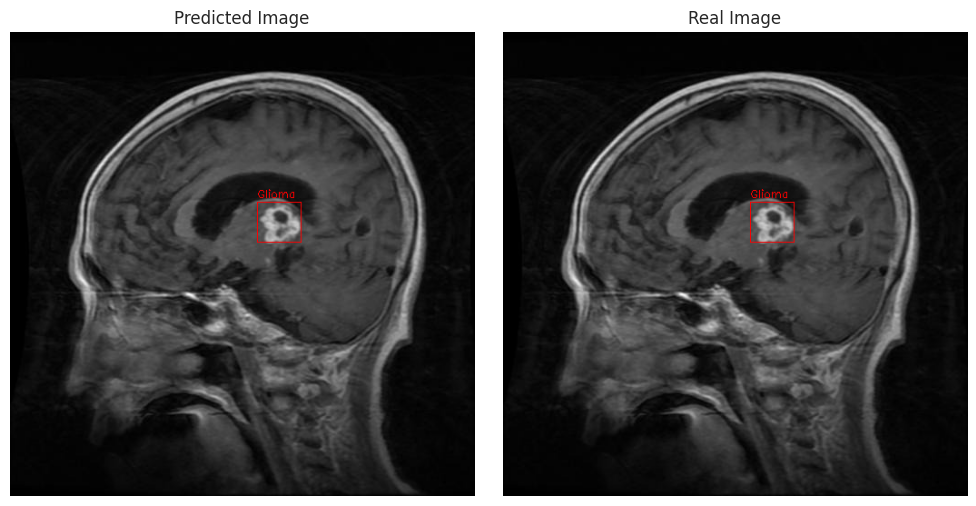

In [32]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the test directory
test_dir = '/kaggle/input/tumor1234/Tumor_data/Tumor_data/Test'

# List all classes in the test directory
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Choose a random class and a random file within that class
random_class = random.choice(classes)
images_path = os.path.join(test_dir, random_class, 'images')
labels_path = os.path.join(test_dir, random_class, 'labels')

# List all images in the selected class
image_files = os.listdir(images_path)

# Pick a random image from the class
random_file = random.choice(image_files)
random_file = os.path.splitext(random_file)[0]

# Full paths for the image and label file
img_pred_path = os.path.join(images_path, f'{random_file}.jpg')
label_pred_path = os.path.join(labels_path, f'{random_file}.txt')

# Try loading the predicted image
img_pred = cv2.imread(img_pred_path, 1)
if img_pred is None:
    print(f"Error: Failed to load the predicted image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_pred)

# Try loading the real image
img_real = cv2.imread(img_pred_path, 1)
if img_real is None:
    print(f"Error: Failed to load the real image at {img_pred_path}. Check the file path or file integrity.")
else:
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    draw_bbox(labels_path, random_file, img_real)

# Display images if both loaded successfully
if img_pred is not None and img_real is not None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_pred)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(img_real)
    axes[1].set_title('Real Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not display images due to loading issues.")
